Configure Google Colab env

In [ ]:
%cd drive/MyDrive/Datasets/Iteration_4/csv_files/
% ls

In [ ]:
from google.colab import files
files.upload()

In [28]:
import numpy as np
import pandas as pd
import os
import csv
from math import floor, ceil
import pickle

from tensorflow.keras import utils as np_utils
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.utils import shuffle

# EEGNet-specific imports
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
import seaborn as sns 

K.set_image_data_format('channels_last')

In [29]:
# constants for processing

kernels, chans, samples = 1, 8, 40

# Load and process data

In [30]:
X = pickle.load(open("X_607.pkl", "rb"))
X.shape

(607, 8, 40)

In [31]:
# load labels as y input for EEGNet

y = pd.read_csv("y_607_2classes.csv")
y = y.drop('Unnamed: 0', axis=1)
y = y['0'].to_numpy()

unique, counts = np.unique(y, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 294],
       [  1, 313]])

In [32]:
X, y = shuffle(X, y)

In [33]:
# apply moving average filter to input

X_smooth = np.array(X)
for i in range(X_smooth.shape[0]):
  for j in range(X_smooth.shape[1]):
    X_smooth[i, j, :] = np.convolve(X_smooth[i,j], np.ones(10), 'same') / 10
X_smooth = X_smooth/10**6

X = np.array(X_smooth)

In [34]:
# extract subsets
train_subset_idx = ceil(X.shape[0]*0.8)
valid_subset_idx = train_subset_idx + ceil(X.shape[0]*0.1)

X_train      = X[0:train_subset_idx]
Y_train      = y[0:train_subset_idx]
X_validate   = X[train_subset_idx:valid_subset_idx]
Y_validate   = y[train_subset_idx:valid_subset_idx]
X_test       = X[valid_subset_idx:]
Y_test       = y[valid_subset_idx:]

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train, num_classes=2)
Y_validate   = np_utils.to_categorical(Y_validate, num_classes=2)
Y_test       = np_utils.to_categorical(Y_test, num_classes=2)

# convert data to NHWC (trials, channels, samples, kernels) format
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_validate.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

print('Y_train shape:', Y_train.shape)

X_train shape: (486, 8, 40, 1)
486 train samples
61 validate samples
60 test samples
Y_train shape: (486, 2)


# Training model

In [35]:
# initialize model
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, 
               dropoutRate = 0.5, kernLength = 32, F1 = 32, D = 4, F2 = 32, 
               dropoutType = 'Dropout')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 40, 1)]        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 40, 32)         1024      
                                                                 
 batch_normalization_3 (Batc  (None, 8, 40, 32)        128       
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 40, 128)       1024      
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 40, 128)       512       
 hNormalization)                                                 
                                                           

In [36]:
adam = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
class_weights = {0:1, 1:1}

In [37]:
# train model
fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 150, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer],verbose = 2, class_weight = class_weights)

Epoch 1/150

Epoch 00001: val_loss improved from inf to 0.69313, saving model to /tmp/checkpoint.h5
16/16 - 1s - loss: 0.7211 - accuracy: 0.4835 - val_loss: 0.6931 - val_accuracy: 0.4918 - 881ms/epoch - 55ms/step
Epoch 2/150

Epoch 00002: val_loss improved from 0.69313 to 0.69310, saving model to /tmp/checkpoint.h5
16/16 - 0s - loss: 0.6867 - accuracy: 0.5165 - val_loss: 0.6931 - val_accuracy: 0.4918 - 120ms/epoch - 7ms/step
Epoch 3/150

Epoch 00003: val_loss improved from 0.69310 to 0.69308, saving model to /tmp/checkpoint.h5
16/16 - 0s - loss: 0.6870 - accuracy: 0.5412 - val_loss: 0.6931 - val_accuracy: 0.4918 - 123ms/epoch - 8ms/step
Epoch 4/150

Epoch 00004: val_loss improved from 0.69308 to 0.69303, saving model to /tmp/checkpoint.h5
16/16 - 0s - loss: 0.6803 - accuracy: 0.5720 - val_loss: 0.6930 - val_accuracy: 0.5574 - 115ms/epoch - 7ms/step
Epoch 5/150

Epoch 00005: val_loss improved from 0.69303 to 0.69296, saving model to /tmp/checkpoint.h5
16/16 - 0s - loss: 0.6864 - accurac

In [40]:
# load optimal weights saved in training process
model.load_weights('/tmp/checkpoint.h5')

In [41]:
# predict
probs = model.predict(X_test)
preds = probs.argmax(axis = -1)  
acc = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.566667 


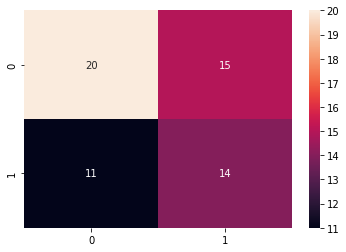

In [42]:
Y_test_decoded = np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_true=Y_test_decoded, y_pred=preds)
sns.heatmap(cm, annot=True, fmt="d")

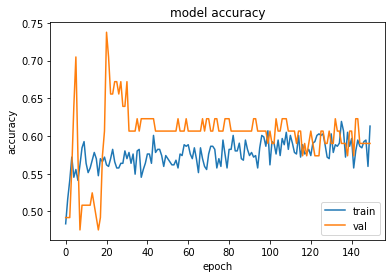

In [43]:
# summarize history for accuracy
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

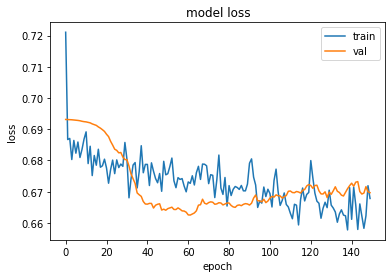

In [44]:
# summarize history for loss
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model.save('test-model')